In [106]:
import os
import warnings
import wave
import random

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydub import AudioSegment
from scipy.io import wavfile

warnings.filterwarnings("ignore")

In [2]:
DATA = 'data/'
PROCESSED_DATA = 'processed_data/'
PREFERED_FILE_FORMAT = 'wav'

In [117]:
data_file_paths = sorted(['data/'+f for f in os.listdir(path='data')])

file_formats = set([f.split('.')[1]
                    for path in data_file_paths for f in os.listdir(path=path)])

print('file are -', file_formats.__str__()[1:-1], '- formats')

file are - 'mp4', 'm4a', 'mp3', 'wav', 'aac' - formats


##### Install depenencies (tested on ubuntu 19.10)
!pip install pydub
<br>
!apt-get install ffmpeg
<br>
!pip install librosa

In [4]:
"""ALL PATHS ARE FROM MASR DIRECTORY"""


def to_wav(src, dst):
    """ Convert single file to .wav
        Params:
        src - (str) full path to file to convert
        dst - (str) full path and file name where to store converted 
    """
    type_ = src.split('.')[1]
    sound = AudioSegment.from_file(src, type_)
    sound.export(dst, format=PREFERED_FILE_FORMAT)


def convert_all_files_to_wav(src_dir, dst_dir):
    """ Convert all files in dir_name directory
        to .wav formats

        Params:
        src_dir - (str) directory from where to convert files
        dst_dir - (str) directory to where to store converted files

    """
    unconvertables = []
    for fname in os.listdir(path=src_dir):
        src = src_dir + '/' + fname
        dst = dst_dir + '/' + fname.split('.')[0] + '.' + PREFERED_FILE_FORMAT
        try:
            to_wav(src, dst)
        except:
            unconvertables.append(src)
    return unconvertables


def convert_all_folders_to_wav(sound_dirs):
    """ Converts all files from all sound directories

        Params:
        sound_dirs - (list of strs) all dir paths from where to convert
    """
    all_unconvertables = []
    for dir_name in sound_dirs:
        src_dir = DATA + dir_name
        dst_dir = PROCESSED_DATA + dir_name

        if not os.path.isdir(dst_dir):
            os.mkdir(dst_dir)
        unconvertables = convert_all_files_to_wav(src_dir, dst_dir)
        all_unconvertables.extend(unconvertables)
    return all_unconvertables

In [69]:
### Uncomment this to convert and load all sound files ###

# unconvertables = convert_all_folders_to_wav([str(i) for i in range(1, 6)])
# len(unconvertables)

Wav files are 2 type
* A mono file has one channel.
* A stereo file has two channels - left and right.

Some of files are mono and some are stereo so this visualizes both types

In [139]:
DEFAULT_SOUND = PROCESSED_DATA+'1/zviad-noza-1e.wav'
processed_data_file_paths = sorted(['processed_data/'+f for f in os.listdir(path='processed_data')])


def plot_spectrogram(file=DEFAULT_SOUND, figsize=(15, 8), fig_id=1):
    """ Visualizes wav file x axis is time and y is amplitude

        Params:
        file    - (str) wav file name to vizualize
        figsize - (tuple of 2 ints) plot's figure size 
        fig_id  - (Number) figure id if same for two calls plots on
                        same figure if different on different figures
    """
    with wave.open(file, 'r') as wav_file:
        # Extract Raw Audio from Wav File
        signal = np.fromstring(wav_file.readframes(-1), 'Int16')

        # Split the data into channels
        num_channels = wav_file.getnchannels()
        channels = [signal[channel::num_channels]
                    for channel in range(num_channels)]

        # Get time from indices
        sound_length = len(signal)/len(channels)/wav_file.getframerate()
        time_ = np.linspace(0, sound_length, num=len(signal)/len(channels))
        # print('sound length - ', sound_length)
        # Plot
        plt.figure(fig_id, figsize=figsize)
        plt.title(file)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

        for channel in channels:
            plt.plot(time_, channel)
        plt.show()

def plot_all_spectrograms(dirs=processed_data_file_paths, num_fig_per_sound=1, plot_as_scrollable=False):
    """ Plots specified number of sound waves
        (spectograms) 
        
        Params:
        dirs               - (str)     directoryes where are sound files 
        num_fig_per_sound  - (Number)  number of spectogram plots per unique number sound
        plot_as_scrollable - (Boolean) for lots of plot it's nice to scroll between plots
                                       and for small number of plots its better to plot them 
                                       without scroll to easyly compare them
    """
    random.seed(42)
    fig_id = 1
    for dir_name in dirs:
        sound_files = os.listdir(dir_name)
        indices = random.sample(range(1, len(sound_files)), num_fig_per_sound)
        print('='*40, dir_name.split('/')[1], '='*40)
        for i in indices:
            fname = dir_name+'/'+sound_files[i]
            plot_spectrogram(file=fname, figsize=(10, 3), fig_id=fig_id)
            fig_id += 1
    if not plot_as_scrollable:
        js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
        ipd.display(ipd.HTML(js))

======================================== 1 ========================================


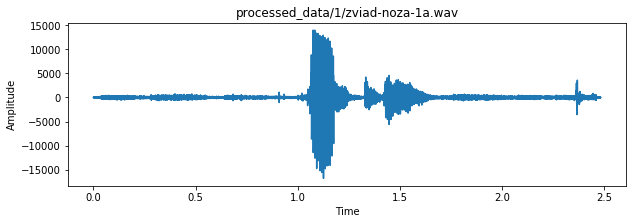

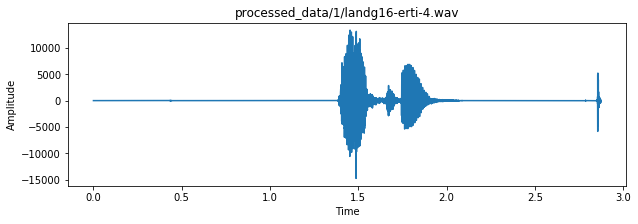

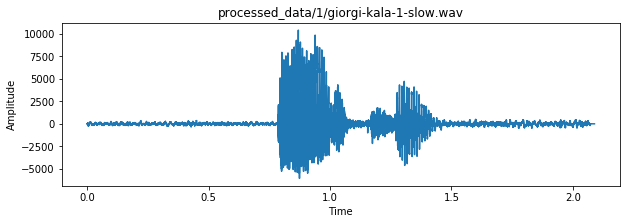

======================================== 2 ========================================


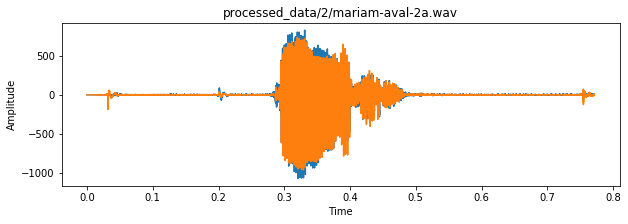

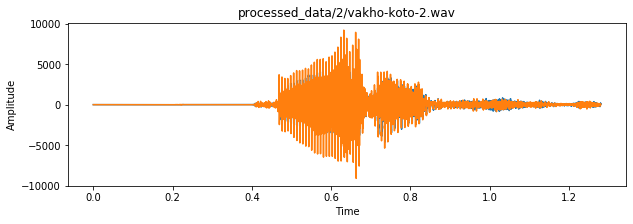

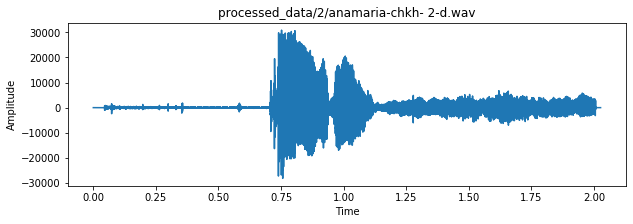

======================================== 3 ========================================


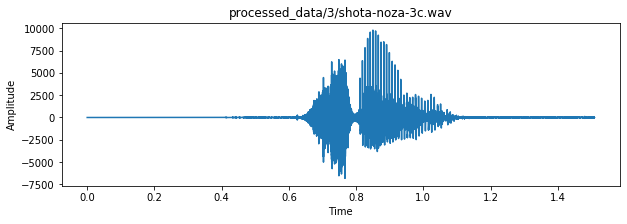

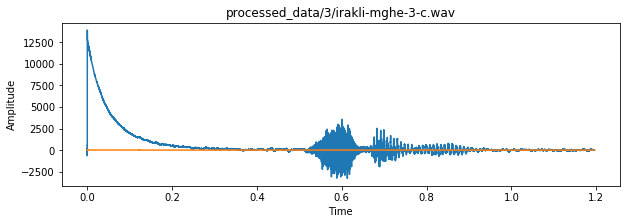

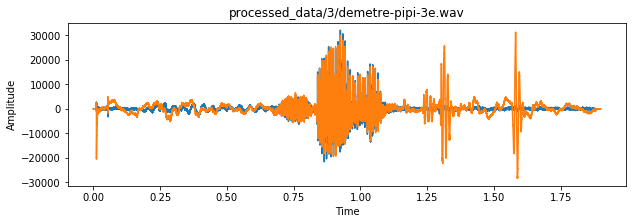

======================================== 4 ========================================


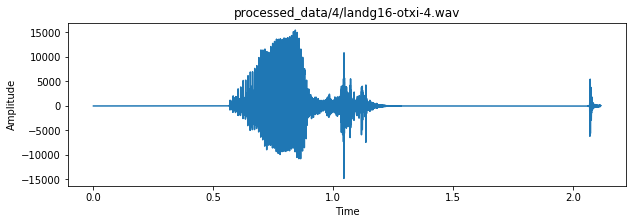

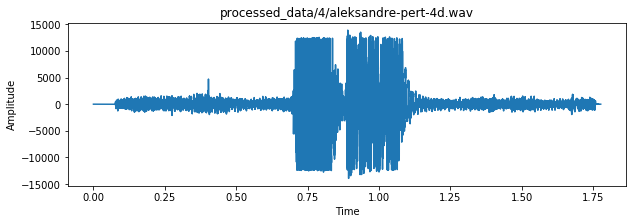

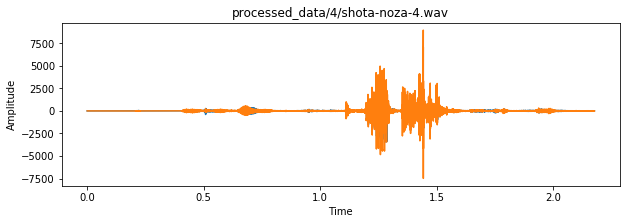

======================================== 5 ========================================


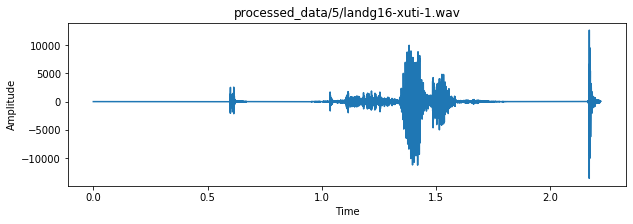

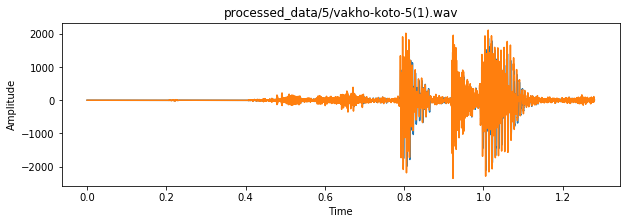

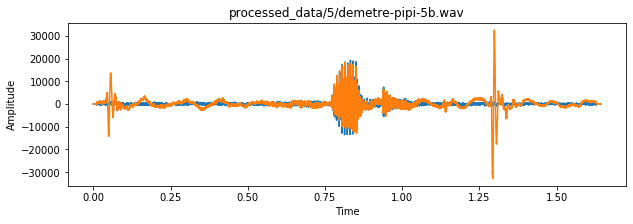

In [140]:
visualize_all_num_sounds()